In [58]:
%run resources/library.py

In [59]:
style_notebook()

# Notebook 6: Counting OSMNx Building Footprints in Voronoi Cells

In [60]:
import osmnx as ox

ox.__version__

'0.10'

## Using OSMNx footprints feature

Let's assume for a while that most 1854 buildings in Soho district still have intact footprints.

In [80]:
SOHO_COORDINATES = (51.513578, -0.136722)

In [81]:
distance = 700
footprints_gdf = \
    ox.footprints.footprints_from_point(SOHO_COORDINATES, distance, \
                footprint_type='building', retain_invalid=False)

In [82]:
footprints_gdf['geometry'].head()

4372002     POLYGON ((-0.1278493 51.5092508, -0.1284233 51...
10811256    POLYGON ((-0.1440521 51.5186547, -0.1440056 51...
26706806    POLYGON ((-0.1421522 51.5069798, -0.1413182 51...
27922125    POLYGON ((-0.1431039 51.5183198, -0.1430695 51...
28416536    POLYGON ((-0.1282499 51.5177264, -0.1282245 51...
Name: geometry, dtype: object

In [83]:
footprints_gdf['geometry'].centroid.head()

4372002     POINT (-0.1289072363583148 51.50886878638756)
10811256    POINT (-0.1434931157229443 51.51881326478711)
26706806    POINT (-0.1415586528205127 51.50698866859691)
27922125    POINT (-0.1430414183760202 51.51815446703645)
28416536    POINT (-0.1280845786505088 51.51791088165614)
dtype: object

In [84]:
import geopandas as gpd

gpd.__version__

'0.5.1'

## Creating a geodataframe of footprint centroids

The footprint feature of OSMNx allows you to plot polygons of buildings. But to determine of buildings are in voronoi cells, we need to identify buildings by the centroid of polygon vertices. Fortunately, `geometry` columns in Geopandas are native `shapely` objects. We can get polygon centroids by the attribute `centroid`.

In [85]:
footprints_centroid_gdf = gpd.GeoDataFrame(geometry=footprints_gdf['geometry'].centroid)

footprints_centroid_gdf

,geometry
4372002,POINT (-0.1289072363583148 51.50886878638756)
10811256,POINT (-0.1434931157229443 51.51881326478711)
26706806,POINT (-0.1415586528205127 51.50698866859691)
27922125,POINT (-0.1430414183760202 51.51815446703645)
28416536,POINT (-0.1280845786505088 51.51791088165614)
28416571,POINT (-0.127818111335119 51.51750283174328)
30734422,POINT (-0.1266435168407795 51.50882032510657)
30734455,POINT (-0.1267574060639324 51.5082783317942)
31327771,POINT (-0.1283160706146249 51.50993014520074)
31467151,POINT (-0.1267499728296392 51.50899599217346)


## Reuse the code for identifying death locations within Voronoi cells

In [67]:
# Read the data.
polygons = gpd.GeoDataFrame.from_file('outputs/clipped_voronoi.shp')
points = footprints_centroid_gdf

# Make a copy because I'm going to drop points as I
# assign them to polys, to speed up subsequent search.
pts = points.copy() 

# We're going to keep a list of how many points we find.
pts_in_polys = []

# Loop over polygons with index i.
for i, poly in polygons.iterrows():

    # Keep a list of points in this poly
    pts_in_this_poly = []

    # Now loop over all points with index j.
    for j, pt in pts.iterrows():
        if poly.geometry.contains(pt.geometry):
            # Then it's a hit! Add it to the list,
            # and drop it so we have less hunting.
            pts_in_this_poly.append(pt.geometry)
            pts = pts.drop([j])

    # We could do all sorts, like grab a property of the
    # points, but let's just append the number of them.
    pts_in_polys.append(len(pts_in_this_poly))

# Add the number of points for each poly to the dataframe.
polygons['points_in_voronoi'] = gpd.GeoSeries(pts_in_polys)

What we have now is a geodataframe with the number of building centroids found in each Voronoi polygon.

In [86]:
clipped_voronoi_buildings_gdf = \
    polygons.rename(columns={'vorpoint_l':'vorpoint_lat','vorpoint_1':'vorpoint_lon'})

clipped_voronoi_buildings_gdf

,vorpoint_lat,vorpoint_lon,FID,Street,geometry,points_in_voronoi
0,51.513876,-0.139586,251,Kingly Street,POLYGON ((-0.1410574856914448 51.5114220613506...,177
1,51.511295,-0.138199,257,Warwick Street,POLYGON ((-0.1367728122831771 51.5087767672292...,141
2,51.514906,-0.139671,252,Ramillies Place,POLYGON ((-0.1419090932168653 51.5142027957054...,104
3,51.511542,-0.135919,255,Bridle Lane,POLYGON ((-0.1365516926565943 51.5087101756211...,102
4,51.513341,-0.136668,250,Broadwick Street,POLYGON ((-0.1363983824619002 51.5175220086050...,325
5,51.512139,-0.133594,254,Rupert Street,POLYGON ((-0.1332910681829834 51.5174454495886...,227
6,51.510019,-0.133962,256,Regent Street,POLYGON ((-0.1313808776576417 51.5097731958019...,59
7,51.512354,-0.131630,253,Dean Street,POLYGON ((-0.1300551818525016 51.5135868616314...,252


Let's save these to files.

In [87]:
clipped_voronoi_buildings_gdf.to_file('outputs/clipped_voronoi_buildings.shp')
clipped_voronoi_buildings_gdf.to_file("outputs/clipped_voronoi_buildings_gdf.json", \
                                      driver="GeoJSON")

## Create the barchart for buildings in Voronoi cells

In [88]:
import pandas as pd

pd.__version__

'0.24.2'

Text(0.5, 0, 'Building Count')

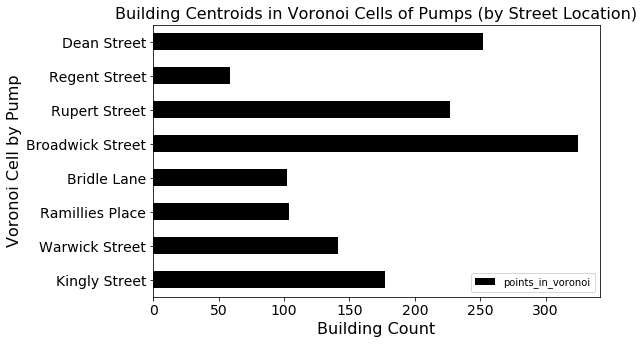

In [89]:
ax = pd.DataFrame(clipped_voronoi_buildings_gdf)\
    .plot.barh(y='points_in_voronoi', x='Street', color='k', figsize=(8,5))
ax.set_title('Building Centroids in Voronoi Cells of Pumps (by Street Location)', \
             fontsize=16)
ax.tick_params(axis = 'both', which = 'major', labelsize = 14)
ax.set_ylabel('Voronoi Cell by Pump', fontsize=16)
ax.set_xlabel('Building Count', \
              fontsize=16)

## Merge the two geodataframes as Pandas dataframes with essential columns to plot two barcharts

In [91]:
death_locations_df = gpd.read_file('outputs/clipped_voronoi_counts.shp')\
    [['FID','points_in_','Street']].rename(columns={'points_in_':'death_locations'})

death_locations_df

,FID,death_locations,Street
0,251,38,Kingly Street
1,257,12,Warwick Street
2,252,1,Ramillies Place
3,255,21,Bridle Lane
4,250,137,Broadwick Street
5,254,41,Rupert Street
6,256,0,Regent Street
7,253,0,Dean Street


In [92]:
buildings_df = clipped_voronoi_buildings_gdf[['FID','points_in_voronoi']]\
        .rename(columns={'points_in_voronoi':'buildings'})

buildings_df

,FID,buildings
0,251,177
1,257,141
2,252,104
3,255,102
4,250,325
5,254,227
6,256,59
7,253,252


In [93]:
voronoi_deaths_buildings_df = pd.merge(death_locations_df, buildings_df, \
                                       on='FID', how='inner')

voronoi_deaths_buildings_df

,FID,death_locations,Street,buildings
0,251,38,Kingly Street,177
1,257,12,Warwick Street,141
2,252,1,Ramillies Place,104
3,255,21,Bridle Lane,102
4,250,137,Broadwick Street,325
5,254,41,Rupert Street,227
6,256,0,Regent Street,59
7,253,0,Dean Street,252


## Plotting the two barcharts together...

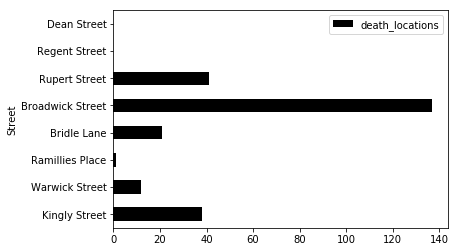

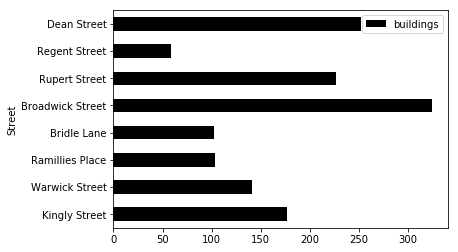

In [94]:
import matplotlib.pyplot as plt

# here are the two plots
ax = pd.DataFrame(voronoi_deaths_buildings_df)\
    .plot.barh(y='death_locations', x='Street', color='k')
ax = pd.DataFrame(voronoi_deaths_buildings_df)\
    .plot.barh(y='buildings', x='Street', color='k')